# <center>Исследование данных HR-агенства<center>

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе анализа данных необходимо выяснить какие факторы влияют на зарплату специалиста Data Scientist и ответить на следующие вопросы HR-агенства:

* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Для ответов на эти вопросы HR-агенство предоставило набор данных, который содержит следующие столбцы:

* *work_year* - Год, в котором была выплачена зарплата.
* *experience_level* - Опыт работы на этой должности в течение года со следующими возможными значениями:
  * EN — Entry-level/Junior;
  * MI — Mid-level/Intermediate;
  * SE — Senior-level/Expert;
  * EX — Executive-level/Director.
* *employment_type*	- Тип трудоустройства для этой роли:
  * PT — неполный рабочий день;
  * FT — полный рабочий день;
  * CT — контракт;
  * FL — фриланс.
* *job_title*	- Роль, в которой соискатель работал в течение года.
* *salary*	- Общая выплаченная валовая сумма заработной платы.
* *salary_currency*	- Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* *salary_in_usd* -	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* *employee_residence*	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* *remote_ratio*	- Общий объём работы, выполняемой удалённо. Возможные значения:
  * 0 — удалённой работы нет (менее 20 %);
  * 50 — частично удалённая работа;
  * 100 — полностью удалённая работа (более 80 %).
* *company_location*	- Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* *company_size*	Среднее количество людей, работавших в компании в течение года:
  * S — менее 50 сотрудников (небольшая компания);
  * M — от 50 до 250 сотрудников (средняя компания);
  * L — более 250 сотрудников (крупная компания).

Оригинальный датасет: [“Data Science Job Salaries”](kaggle.com)

## Загрузка данных

In [145]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные загружаем на Google Drive по [ссылке](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip). В качестве резервного источника данных (на случай проблем с доступом в Internet) файл с данными скачан в каталог *data* текущего проекта и переименован в ds_salaries.zip.

In [146]:
# Загружаем набор данных
data = pd.read_csv('https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip')
#data = pd.read_csv('data/ds_salaries.zip') # резервный источник данных
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [147]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [148]:
data.info()  # получаем сведения о НД

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Набор данных содержит 607 строк с данными. Пропуски отсутствуют. Присутствует столбец Unnamed, являющийся индексом строк, который не имеет информативности и подлежит удалению в дальнейшем.  
Проверям набор данных на соджержание дубликатов.

In [149]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


Определяем выбросы, для чего построим распределение заработной платы по всему набору данных.

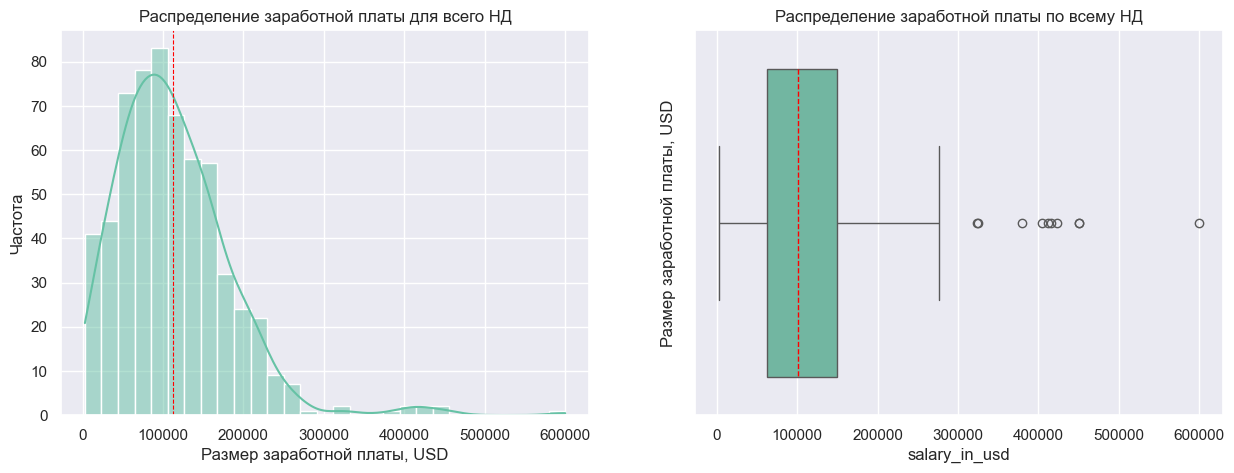

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы, USD', ylabel='Частота')
axes[0].set_title('Распределение заработной платы для всего НД')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы, USD')
axes[1].set_title('Распределение заработной платы по всему НД')

plt.show()

In [151]:
# статистические данные по размеру заарботной платы
data_agg = data['salary_in_usd'].describe().round(2).to_frame()  # формируем набор статистических данных
data_agg.columns = ['Размер заработной платы, USD']              # устанавливаем наименования столбца с зааработной платой
data_agg                                                         # выводим набор статистических данных

,"Размер заработной платы, USD"
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Заработная плата имеет распределение близкое к нормальному. Имеются выбросы.

Определяем неинформативные признаки.

In [152]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    top_freq = data[col].value_counts(normalize=True).max()                    # наибольшая относительная частота в признаке
    nunique_ratio = data[col].nunique() / data[col].count()                    # доля уникальных значений от размера признака
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:                                                        # если относительная частота > 95%
        low_information_cols.append(col)                                       # то столбец добавляем в список малоинфформативных признаков
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')         # выводим информацию по признаку
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:                                                   # если доля уникальных значений > 95%
        low_information_cols.append(col)                                       # то столбец добавляем в список малоинфформативных признаков
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')    # выводим информацию по признаку

Unnamed: 0: 100.0% уникальных значений
employment_type: 96.87% одинаковых значений


К неинфоративным признакам добавился признак типа трудоустройства, т.к. в подавляющем большинстве случаев устройства на работу требуется присутствие на рабочем месте в течение полного рабочего дня. Кроме того, в наборе данных существуют еще два признака, которые хоть и не относятся к неинформативным, по сути своей являются излишней информацией, поскольку заменены другим признаком. Это признаки *salary* и *salary_currency*. Кроме того, признаки *employee_residence* и *company_location* по факту являются мультиколлинеарными, т.к. признак *employment_type* в 96.87% случаев имеет значение занятости на полный день, что означает совпадение значений вышеозначенных признаков. Большее влияние на заработную плату специалистов DS оказывает локация специалиста, нежели локация компании, т.к. компании предпочитают платить зарплату исходя из характерной заплаты специалистов в конкретной стране. Таким образом, признаки *employment_type*, *salary*, *salary_currency* и *company_location* необходимо удалить.  

In [153]:
# Удаляем эти признаки.
temp = ['salary', 'salary_currency', 'company_location']        # инициируем список расширения малоинформативных признаков
low_information_cols.extend(temp)                               # расширяем список малоинформативных признаков
cl_data = data.drop(low_information_cols, axis=1)               # удаляем малоинформативные признаки
print(f'Результирующее число признаков: {cl_data.shape[1]}')    # выводи результат по количесву признаков

Результирующее число признаков: 7


Определяем факторы, влияющие на заработную плату специалиста Data Scientist. Алгоритм выполнения этой задачи следующий:

1. Определяем количество уникальных значений для каждого категориального признака.
2. Определяем алгоритм кодировки признака.
3. Выполняем кодировку признаков.
4. Составляем матрицу корелляции признаков.
5. Выбираем признаки, которые имеют максимальный коэффициент корелляции по отношению к зарплате.

In [154]:
# формируем НД для специальности DS
cp_data = cl_data[cl_data['job_title'] == 'Data Scientist']                       # формируем выборку по специальности DS 
cp_data = cp_data.drop(['job_title'], axis=1)                                     # удаляем малоинформативные признаки              
# Выводим количество уникальных значений категориальных признаков
print("Признак 'experience_level':  ", cp_data['experience_level'].nunique())     # выводим к-во уникальных значений для 'experience_level'
print("Признак 'employee_residence':", cp_data['employee_residence'].nunique())   # выводим к-во уникальных значений для 'employee_residence'
print("Признак 'company_size':      ", cp_data['company_size'].nunique())         # выводим к-во уникальных значений для 'company_size'

Признак 'experience_level':   3
Признак 'employee_residence': 27
Признак 'company_size':       3


Для признаков *'experience_level'* и *'company_size'* применим порядковый метод кодирования, а для признака *'employee_residence'* применим метод бинарного кодирования.

In [155]:
# кодируем признак 'experience_level'
ord_encoder = ce.OrdinalEncoder(mapping=[{                            # создаем объект OrdinalEncoder, 
    'col' : 'experience_level',                                       # col - имя столбца, 
	'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}}])                # mapping - словарь с описанием кодировки
# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(cp_data[['experience_level']])   # преобразуем признак в числовой
# добавляем результат к исходному DataFrame
cp_data = cp_data.drop(['experience_level'], axis=1)                  # удаляем из НД строковый признак 
cp_data = pd.concat([cp_data, data_bin], axis=1)                      # добавляем в ДН числовой признак

In [156]:
# кодируем признак 'company_size'
ord_encoder = ce.OrdinalEncoder(mapping=[{                        # создаем объект OrdinalEncoder, 
    'col' : 'company_size',                                       # col - имя столбца, 
	'mapping': {'S': 1, 'L': 2, 'M': 3}}])                        # mapping - словарь с описанием кодировки
# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(cp_data[['company_size']])   # преобразуем признак в числовой
# добавляем результат к исходному DataFrame
cp_data = cp_data.drop(['company_size'], axis=1)                  # удаляем из НД строковый признак 
cp_data = pd.concat([cp_data, data_bin], axis=1)                  # добавляем в ДН числовой признак

In [157]:
# кодируем признак 'employee_residence'
bin_encoder = ce.BinaryEncoder(cols=['employee_residence'])           # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(cp_data['employee_residence'])   # кодируем столбец
cp_data = cp_data.drop(['employee_residence'], axis=1)                # удаляем из НД строковый признак 
cp_data = pd.concat([cp_data, type_bin], axis=1)                      # добавляем в ДН бинарные признаки
cp_data.head()

,work_year,salary_in_usd,remote_ratio,experience_level,company_size,employee_residence_0,employee_residence_1,employee_residence_2,employee_residence_3,employee_residence_4
0,2020,79833,0,2,2,0,0,0,0,1
7,2020,35735,50,2,2,0,0,0,1,0
10,2020,51321,0,1,1,0,0,0,1,1
11,2020,40481,0,2,2,0,0,1,0,0
12,2020,39916,0,1,3,0,0,0,1,1


In [158]:
cp_data.corr()  # строим матрицу корреляций между признакми НД

,work_year,salary_in_usd,remote_ratio,experience_level,company_size,employee_residence_0,employee_residence_1,employee_residence_2,employee_residence_3,employee_residence_4
work_year,1.000000,0.393396,0.070287,0.427628,0.592480,0.063671,0.355276,-0.060352,-0.196268,-0.295628
salary_in_usd,0.393396,1.000000,0.192270,0.599262,0.387544,-0.292528,0.576161,-0.416298,-0.349044,-0.392175
remote_ratio,0.070287,0.192270,1.000000,0.114779,0.125757,-0.046057,0.329817,-0.033691,-0.309679,-0.233302
experience_level,0.427628,0.599262,0.114779,1.000000,0.319802,-0.189628,0.351967,-0.218252,-0.253023,-0.255591
company_size,0.592480,0.387544,0.125757,0.319802,1.000000,-0.169791,0.273630,-0.127253,-0.150257,-0.129437
employee_residence_0,0.063671,-0.292528,-0.046057,-0.189628,-0.169791,1.000000,-0.244804,0.046291,0.238768,0.105409
employee_residence_1,0.355276,0.576161,0.329817,0.351967,0.273630,-0.244804,1.000000,-0.501960,-0.553040,-0.533461
employee_residence_2,-0.060352,-0.416298,-0.033691,-0.218252,-0.127253,0.046291,-0.501960,1.000000,0.318758,0.360541
employee_residence_3,-0.196268,-0.349044,-0.309679,-0.253023,-0.150257,0.238768,-0.553040,0.318758,1.000000,0.514553
employee_residence_4,-0.295628,-0.392175,-0.233302,-0.255591,-0.129437,0.105409,-0.533461,0.360541,0.514553,1.000000


Наибольшие коэффициенты корреляции зарплаты наблюдаются с признакми опыта работы и страны проживания. Т.е. наибольщее влияние на уровень оплаты труда специалиста DS оказывают опыт работы и страна проживания. Остальные признаки достаточно слабо, но тоже влияют на зарплату специалиста DS.

### Распределение заарботной платы специалистов DS по годам.

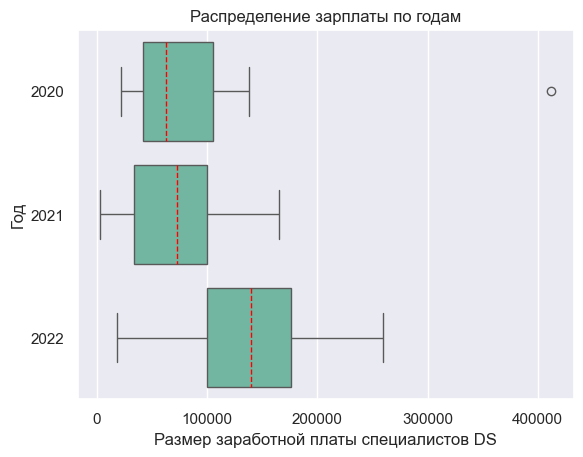

In [159]:
# выбираем данные по специалистам DS
ds_data = cl_data[cl_data['job_title'] == 'Data Scientist']
# формируем и выводим диаграммы распределения ЗП по годам
ax = sns.boxplot(ds_data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы специалистов DS', ylabel='Год')
plt.title('Распределение зарплаты по годам')
plt.show()

In [98]:
# выводим статистичекие данные по годам
data_agg = ds_data.groupby('work_year')['salary_in_usd'].describe().round(2)   # группируем данные по году
print('Зарплата специалистов DS в зависимости от года работы')                 # выводим заголовок данных
data_agg                                                                       # выводим статистические данные

Зарплата специалистов DS в зависимости от года работы


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Наблюдается рост заработной платы специалистов DS по годам. Статистическую значимость различий определим в следующем разделе при проведении статистического теста. 

### Соотношение заработной платы специалистов DS и DE в 2022 году.

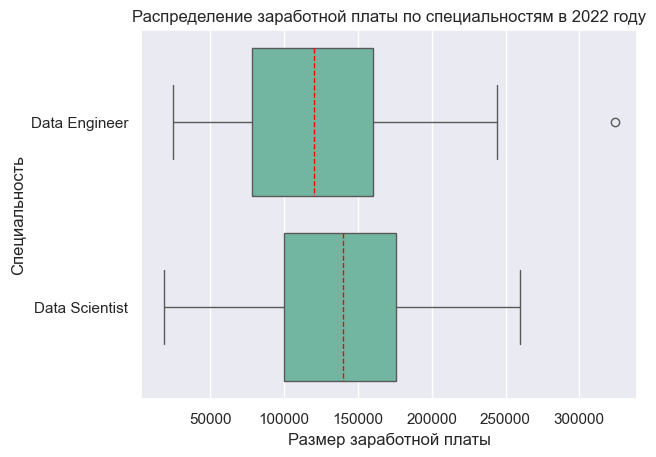

In [99]:
# выбираем данные по специалистам DS
ds_mask = cl_data['job_title'] == 'Data Scientist'  # маска для специалистов DS
de_mask = cl_data['job_title'] == 'Data Engineer'   # маска для специалистов DE
year_mask = cl_data['work_year'] == 2022            # маска для периода работы
dy_data = cl_data[(ds_mask | de_mask) & year_mask]  # формируем необходимую выборку из НД
# строим распределение заработной платы по специальностям в 2022 году
ax = sns.boxplot(dy_data, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Специальность')
plt.title('Распределение заработной платы по специальностям в 2022 году')
plt.show()

In [100]:
# выводим статисстичекие данные по ЗП в 2022 году
data_agg = dy_data.groupby('job_title')['salary_in_usd'].describe().round(2)  # группируем данные по специальностям
print('Зарплата специалистоd DS и DE в 2022 году')                            # выводим заголовок данных
data_agg                                                                      # выводим статистические данные

Зарплата специалистоd DS и DE в 2022 году


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,89.0,126375.70,55954.40,25000.0,78526.0,120000.0,160000.0,324000.0
Data Scientist,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Заработная плата  у специалистов DS в 2022 году в среднем выше заработной платы специалистов DE. Статистическую значимость различий определим в следующем разделе при проведении статистического теста.

### Соотношение зарплаты специалистов DS в компаниях различной величины

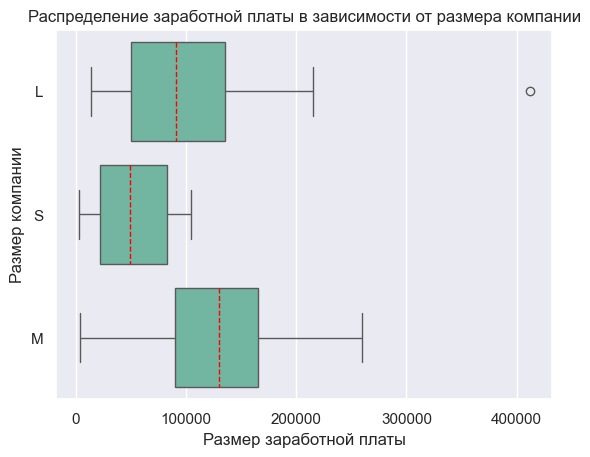

In [101]:
# формируем и выводим диаграммы распределения ЗП для компний различных размеров
ax = sns.boxplot(ds_data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Размер компании')
plt.title('Распределение заработной платы в зависимости от размера компании')
plt.show()

In [102]:
# выводим статисстичекие данные по ЗП в компниях различной величины
data_agg = ds_data.groupby('company_size')['salary_in_usd'].describe().round(2)  # группируем данные по размеру компаний
print('Зарплата специалистов DS в зависимости от размера компании')              # выводим заголовок данных
data_agg                                                                         # выводим статистические данные

Зарплата специалистов DS в зависимости от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Заработная плата специалистов DS в компаниях разного размера различна. Максимальная зарплата в компаниях среднего размера, минимальная в малых компаниях. Статистическую значимость различий определим в следующем разделе при проведении статистического теста.

### Определяем связь между наличием должностей DS и DE и размером компании

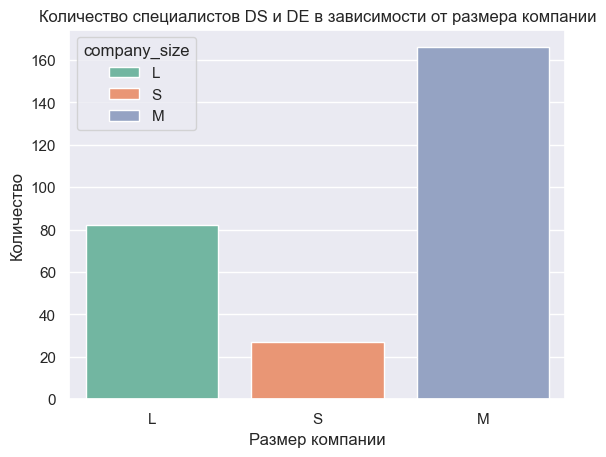

In [103]:
dse_data = cl_data[ds_mask | de_mask]
# строим диаграмму количества РМ дл DS и DE в компниях разной величины
ax = sns.countplot(data=dse_data, x=data['company_size'], hue='company_size')
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Количество специалистов DS и DE в зависимости от размера компании')
plt.show()

В компаниях различных размеров различное количество рабочих мест для специалистов DS и DE. Статистическую значимость различий определим в следующем разделе при проведении статистического теста.

## Статистический анализ данных

In [104]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))  # выводим значение статистической значимости
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))  # выводим значение статистической значимости
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза: ежегодного роста зарплат у специалистов DS не наблюдается: 2020 ($\mu_1$), 2021 ($\mu_2$), 2022 ($\mu_3$).  
$$H_0: \mu_1 = \mu_2 = \mu_3$$  
Альтернативная гипотеза: наблюдается ежегодный рост зарплат у специалистов DS: 2020 ($\mu_1$), 2021 ($\mu_2$), 2022 ($\mu_3$). 
$$H_1: \mu_1 < \mu_2 < \mu_3$$ 

**Проверка признакка на нормальность**  
Спомощью теста Шапиро-Уилка проверим, распределен ли признак нормально.

In [105]:
# значения заработной платы по годам
year_2020 = ds_data.loc[ds_data['work_year']==2020, 'salary_in_usd']
year_2021 = ds_data.loc[ds_data['work_year']==2021, 'salary_in_usd']
year_2022 = ds_data.loc[ds_data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020 года:')              #выводим заголовок для 2020 года
result = stats.shapiro(year_2020)    # проводим тест на нормальность распределения ЗП
decision_normality(result[1])        # оцениваем нормальность распределения ЗП

print('Для 2021 года:')              # выводим заголовок для 2021 года
result = stats.shapiro(year_2021)    # проводим тест на нормальность распределения ЗП
decision_normality(result[1])        # оцениваем нормальность распределения ЗП

print('Для 2022 года:')              # выводим заголовок для 2022 года
result = stats.shapiro(year_2022)    # проводим тест на нормальность распределения ЗП
decision_normality(result[1])        # оцениваем нормальность распределения ЗП

Для 2020 года:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021 года:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022 года:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выбираем подходящий статистический тест**

Для этого ответим на следующие вопросы:  

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в долларах»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведем тест**

In [106]:
# проводим тест
_, p = stats.kruskal(year_2020, year_2021, year_2022)     # проверяем статистическую значимость
decision_hypothesis(p)                                    # проверяем гипотезы на приемлимость

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод** 

Наблюдается ежегодный рост заработной платы специалистов DS.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза: зарплаты в 2022 году у специалистов DS ($\mu_1$) равна зарплате специлистов DE ($\mu_2$).  
$$H_0: \mu_1 = \mu_2$$  
Альтернативная гипотеза: зарплаты в 2022 году у специалистов DS ($\mu_1$) не равна зарплате специалистов DE ($\mu_2$). 
$$H_1: \mu_1 \neq \mu_2$$ 

**Проверка признакка на нормальность**  
Спомощью теста Шапиро-Уилка проверим, распределен ли признак нормально.

In [107]:
# значения заработной платы по годам
ds = dy_data.loc[dy_data['job_title']=='Data Scientist', 'salary_in_usd']
de = dy_data.loc[dy_data['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')     # выводим заголовок для специальности DS
result = stats.shapiro(ds)       # проводим тест на нормальность распределения ЗП 
decision_normality(result[1])    # оцениваем нормальность распределения ЗП

print('Для Data Engineer:')      # выводим заголовок для специальности DE
result = stats.shapiro(de)       # проводим тест на нормальность распределения ЗП
decision_normality(result[1])    # оцениваем нормальность распределения ЗП

Для Data Scientist:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer:
p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выбираем подходящий статистический тест**

Для этого ответим на следующие вопросы:  

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в долларах»? — Количественный.
* Сколько сравниваемых групп? — две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведем тест**

In [108]:
# проводим тест
_, p = stats.mannwhitneyu(ds, de, alternative='two-sided')   # проверяем статистическую значимость
decision_hypothesis(p)                                       # проверяем гипотезы на приемлимость

p-value = 0.155
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Заработная плата специалистов DS не отличаетсят от заработной платы специалистов DE в 2022 году.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза: величина заработной платы у специалистов DS в компаниях различных размеров не отличается: 'S' ($\mu_1$), 'M' ($\mu_2$), 'L' ($\mu_3$).  
$$H_0: \mu_1 = \mu_2 = \mu_3$$  
Альтернативная величина заработной платы у специалистов DS в компаниях различных размеров отличается: 'S' ($\mu_1$), 'M' ($\mu_2$), 'L' ($\mu_3$). 
$$H_1: \mu_1 \neq \mu_2 \neq \mu_3$$ 

**Проверка признакка на нормальность**

Спомощью теста Шапиро-Уилка проверим, распределен ли признак нормально.

In [109]:
# значения заработной платы по размерам компний
s_data = ds_data.loc[ds_data['company_size']=='S', 'salary_in_usd']
m_data = ds_data.loc[ds_data['company_size']=='M', 'salary_in_usd']
l_data = ds_data.loc[ds_data['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S компаний:')             # выводим заголовок для малых компаний
result = stats.shapiro(s_data)       # тестируем НД на нормальность распределения НД
decision_normality(result[1])        # определяем нормальность распределения ЗП

print('Для M компаний:')             # выводим заголовок для 
result = stats.shapiro(m_data)       # тестируем НД на нормальность распределения НД
decision_normality(result[1])        # определяем нормальность распределения ЗП

print('Для L компаний:')             # выводим заголовок для 
result = stats.shapiro(l_data)       # тестируем НД на нормальность распределения НД
decision_normality(result[1])        # определяем нормальность распределения ЗП

Для S компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M компаний:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выбираем подходящий статистический тест**

Для этого ответим на следующие вопросы:  

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в долларах»? — Количественный.
* Сколько сравниваемых групп? — три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведем тест**

In [110]:
# проводим тест
_, p = stats.kruskal(s_data, m_data, l_data)      # проверяем статистическую значимость
decision_hypothesis(p)                            # проверяем гипотезы на приемлимость

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Зрабаботная плата специалистов DS в компаниях различных размерах различная. 

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: связь между наличием должностей Data Scientist и Data Engineer и размером компании отсутствует.  
*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании существует взаимосвязь.

**Выбираем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [111]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(dse_data['job_title'], dse_data['company_size'])
# выводим таблицу сопряженности
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [112]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)   # определяем статистическую значимость
decision_hypothesis(p)                             # проверяем гипотезы на приемлимость

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Между наличием должностей Data Scientist и Data Engineer и размером компании существует статистически значимая связь.

## Итоговые результаты исследования

* Наблюдается ежегодный рост заработной платы специалистов DS.
* Нет оснований утверждать, что заработная плата специалистов DS оличается заработной платы специалистов DE в 2022 году.
* Зрабаботная плата специалистов DS в компаниях различных размерах различная.
* Наличие должностей Data Scientist и Data Engineer и размеры компаний взаимосвязаны.

## Дополнительные исследования

В качестве дополнительного исследования дадим ответы на следующие вопросы:
1. Существует ли связь между наличием должностей с квалификацией Senior-level/Expert и Executive-level/Director и размером компании?
2. Отличается ли заработная плата специалистов в России и Индии?

### Описательный анализ данных

#### Определяем связь между наличием должностей с квалификацией SE и EX и размером компании

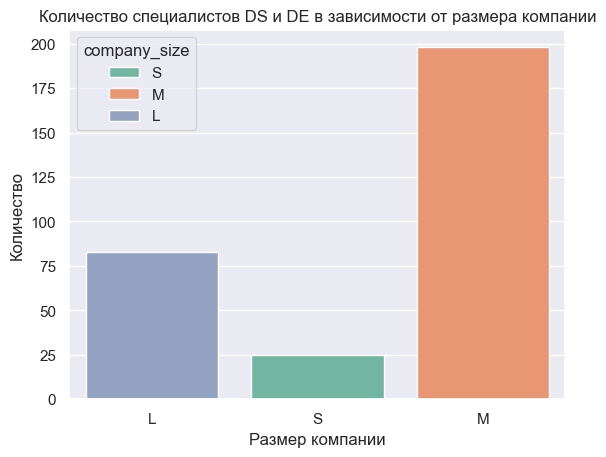

In [117]:
# выбираем данные по специалистам  с квалификацией SE и EX
se_mask = cl_data['experience_level'] == 'SE'  # маска для специалистов SE
ex_mask = cl_data['experience_level'] == 'EX'  # маска для специалистов EX
ex_data = cl_data[se_mask | ex_mask]           # формируем НД для спецов с квалификацией SE и EX
# строим столбчатую диаграмму для количества спецов уровня SE и EX в зависимости от размера компании 
ax = sns.countplot(data=ex_data, x=data['company_size'], hue='company_size')
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Количество специалистов DS и DE в зависимости от размера компании')
plt.show()

В компаниях различных размеров различное количество рабочих мест для специалистов уровня DS и DE. Статистическую значимость различий определим в следующем разделе при проведении статистического теста.

#### Определяем отличие зарплат специалистов DS в России и Индии

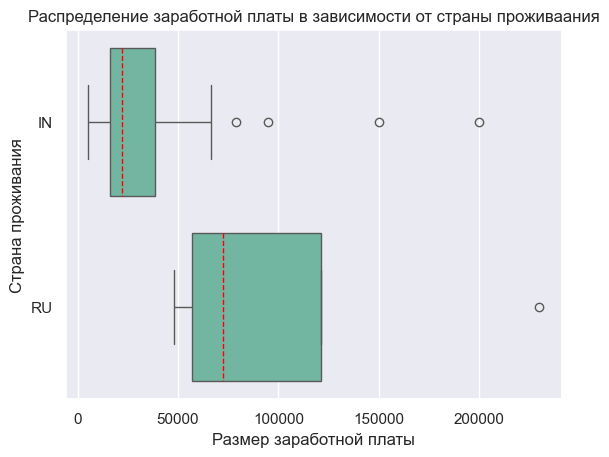

In [114]:
# готовим выборку специалистов DS из России и Индии
ru_mask = cl_data['employee_residence'] == 'RU'   # маска для выборки специалистов DS из России
in_mask = cl_data['employee_residence'] == 'IN'   # маска для выборки специалистов DS из Индии
dsri_data = cl_data[ru_mask | in_mask ]           # получили интересующую нас выборку
# строим распределение заработной платы в зависимости от страны проживания
ax = sns.boxplot(dsri_data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработной платы', ylabel='Страна проживания')
plt.title('Распределение заработной платы в зависимости от страны проживаания')
plt.show()

In [115]:
# получаем статистическую информацию по зарплате для Росии и Индии 
data_agg = dsri_data.groupby('employee_residence')['salary_in_usd'].describe().round(2) # группируем по стране проживания
print('Зарплата специалистов в России и Индии')                                         # выводим заголовок информации
data_agg                                                                                # выводим информацию

Зарплата специалистов в России и Индии


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
IN,30.0,37322.33,43741.19,5409.0,16397.0,22124.0,38812.75,200000.0
RU,4.0,105750.00,84255.07,48000.0,57000.0,72500.0,121250.00,230000.0


Заработная плата у специалистов в России выше заработной платы специалистов в Индии. Статистическую значимость различий определим в следующем разделе при проведении статистического теста.

### Статистический анализ данных

#### Существует ли связь между наличием должностей с квалификацией Senior-level/Expert и Executive-level/Director и размером компании?

**Сформулируем нулевую и альтернативную гипотезы**

*Нулевая гипотеза*: связь между наличием должностей c квалификацией SE и EX и размером компании отсутствует.  
*Альтернативная гипотеза*: между наличием должностей с квалификацией SE и EX и размером компании существует взаимосвязь.

**Выбираем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [119]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(ex_data['experience_level'], ex_data['company_size'])
# выводим таблицу сопряженности
cross_table

company_size,L,M,S
experience_level,,,
EX,11,12,3
SE,72,186,22


In [120]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)  # определяем статистическую значимость
decision_hypothesis(p)                            # проверяем гипотезы на приемлимость

p-value = 0.115
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Не существует статистически значимой связи между уровнем квалификации специалистов SE и EX и размеролм компании.

#### Отличается ли заработная плата специалистов в России и Индии?

**Сформулируем нулевую и альтернативную гипотезы**

Нулевая гипотеза: зарплаты у специалистов в России ($\mu_1$) не отличается от зарплаты специлистов в Индии ($\mu_2$).  
$$H_0: \mu_1 = \mu_2$$  
Альтернативная гипотеза: зарплаты у специалистов в России ($\mu_1$) отличается от зарплаты специалистов в Индии ($\mu_2$). 
$$H_1: \mu_1 \neq \mu_2$$ 

**Проверка признакка на нормальность**  
Спомощью теста Шапиро-Уилка проверим, распределен ли признак нормально.

In [160]:
# значения заработной платы по странам проживания
dsr = dsri_data.loc[dsri_data['employee_residence']=='RU', 'salary_in_usd']
dsi = dsri_data.loc[dsri_data['employee_residence']=='IN', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для России:')                # выводим заголовок для России
result = stats.shapiro(dsr)         # тестируем НД по Росии на нормальность распределения ЗП
decision_normality(result[1])       # определяем нормальность распределения ЗП

print('Для Индии:')                 # выводим заголовок для Индии
result = stats.shapiro(dsi)         # тестируем НД по Индии на нормальность распределения ЗП
decision_normality(result[1])       # определяем нормальность распределения ЗП

Для России:
p-value = 0.077
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Индии:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выбираем подходящий статистический тест**

Для этого ответим на следующие вопросы:  

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в долларах»? — Количественный.
* Сколько сравниваемых групп? — две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведем тест**

In [123]:
# проводим тест
_, p = stats.mannwhitneyu(dsr, dsi, alternative='two-sided')  # определяем статистическую значимость
decision_hypothesis(p)                                        # проверяем гипотезы на приемлимость

p-value = 0.015
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Заработная плата специалистов в России отличаетсят от заработной платы специалистов в Индии.

### Итоговые выводы по дополнительным исследованиям

* Уровень квалификации специалистов SE и EX не связан с наличием рабочих мест для них в компаниях разных размеров.
* Заработная плата специалистов в России выше заработной платы специалистов в Индии.